In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
%config IPCompleter.greedy = True
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
mpl.style.use('ggplot')
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
plt.figure(figsize=(9,9))
plt.rcParams["figure.figsize"] = [9, 9]

<Figure size 648x648 with 0 Axes>

# План работы


1. Получение данных
2. Обнаружение закономерностей и визуализация данных
3. Подготовка данных для алгоритмов МО
4. Представление своего решения

## Housing

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


**Таблица представляет данные по округам Калифорнии**
- долгота
- широта
- средний возраст домов округа
- всего комнат в домах округа
- всего спален в домах округа
- количество проживающих в округе
- количество домов в округе
- средний доход в округе
- средняя стоимость дома в округе
- нахождение относительно океана

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


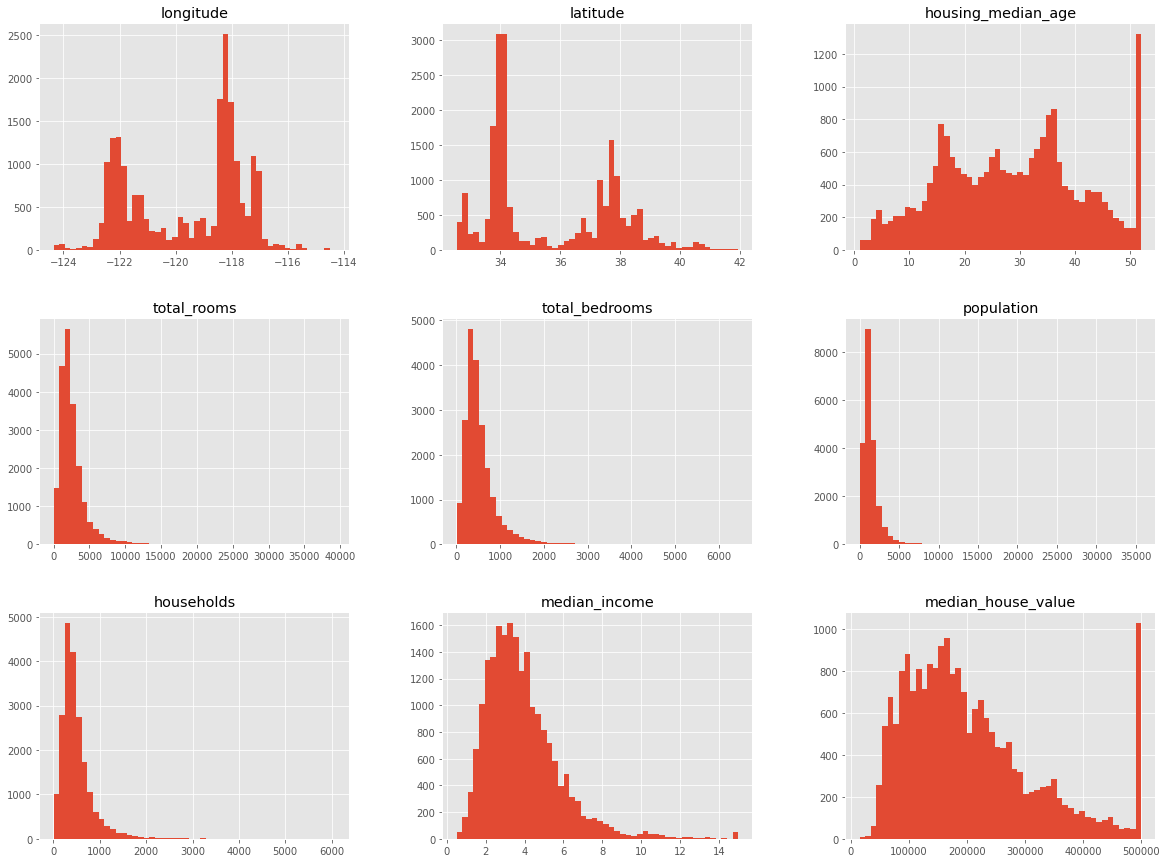

In [10]:
housing.hist(bins=50, figsize=(20,15));

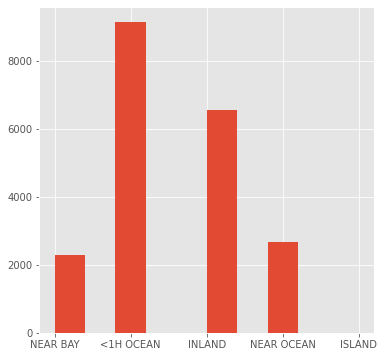

In [11]:
housing.ocean_proximity.hist(figsize=(6,6));

In [12]:
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64

In [13]:
housing['income_cat'] = np.ceil(housing.median_income / 1.5)

In [14]:
housing['income_cat'].value_counts()

3.000     7236
2.000     6581
4.000     3639
5.000     1423
1.000      822
6.000      532
7.000      189
8.000      105
9.000       50
11.000      49
10.000      14
Name: income_cat, dtype: int64

In [15]:
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [16]:
housing['income_cat'].value_counts()

3.000    7236
2.000    6581
4.000    3639
5.000    2362
1.000     822
Name: income_cat, dtype: int64

In [17]:
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000
median_income         0.688
income_cat            0.644
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64

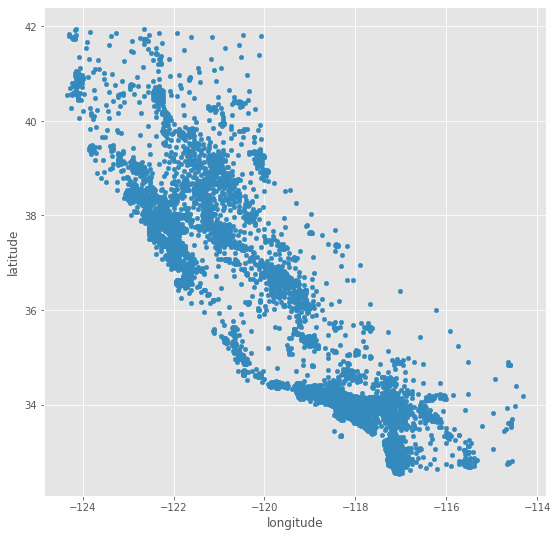

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude');

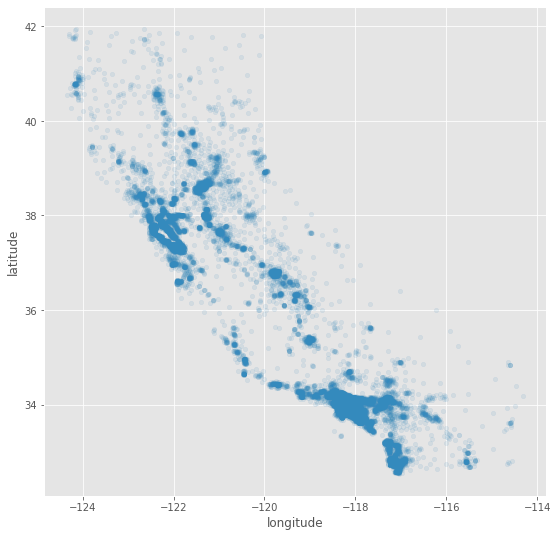

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1);

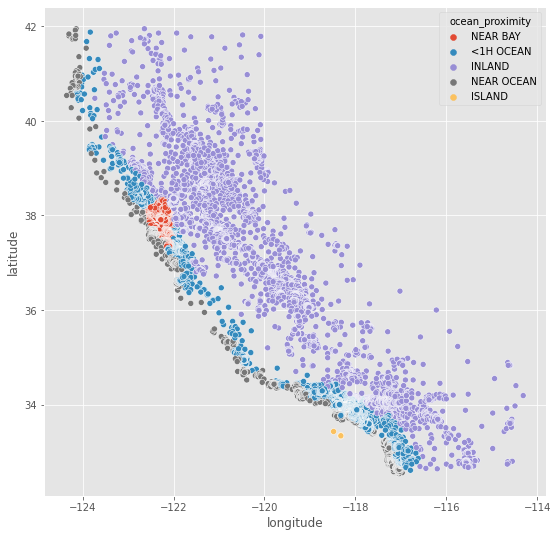

In [23]:
sns.scatterplot(x='longitude', y='latitude', data=housing, hue='ocean_proximity');

Saving figure graphs\[2]housing_prices_scatterplot


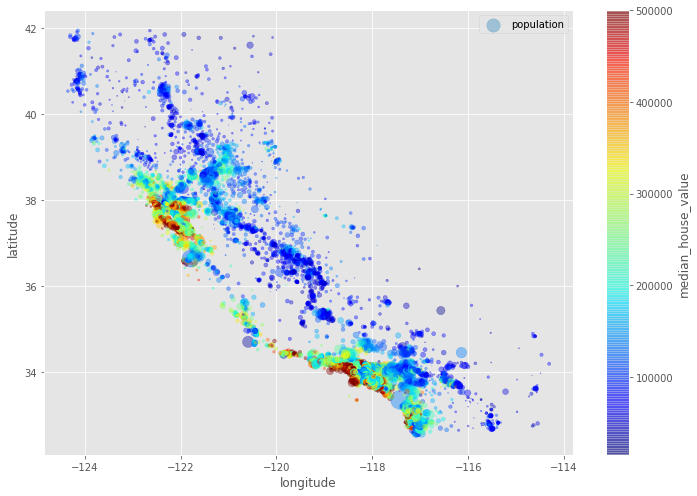

In [20]:
# параметр s отвечает за площадь кругов (чем больше, тем больше население округа); 
# параметр c отвечает за фильтр по цвету относительно средней цены домов в округе
# cmap - окраска, colorbar - легенда раскраски
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population'] /100, 
             c='median_house_value', cmap='jet', colorbar='True', figsize=(10,7), sharex=False, label='population'
)
plt.legend();
save_fig("graphs\[2]housing_prices_scatterplot");

In [145]:
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000
median_income         0.688
income_cat            0.644
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64

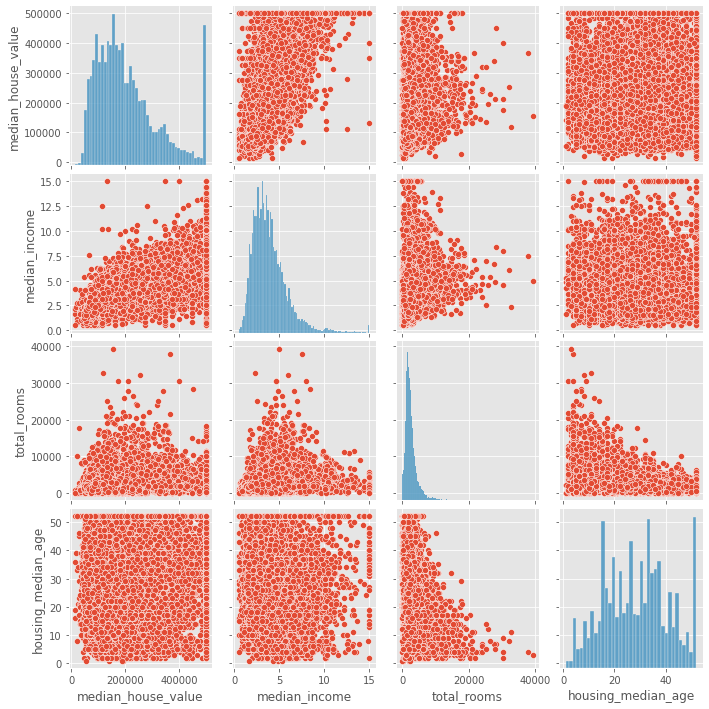

In [146]:
sns.pairplot(housing[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']]);

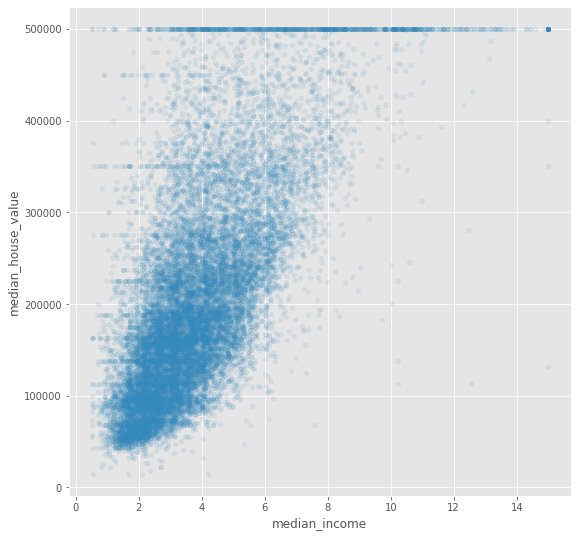

In [147]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);

Saving figure graphs\[2]california_housing_prices_plot


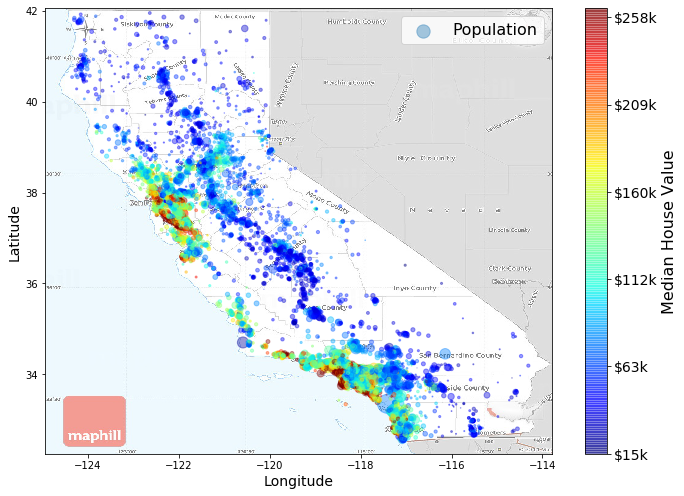

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread('images\california.jpg')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.95, -113.80, 32.25, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("graphs\[2]california_housing_prices_plot")
plt.show()

Saving figure boxplot


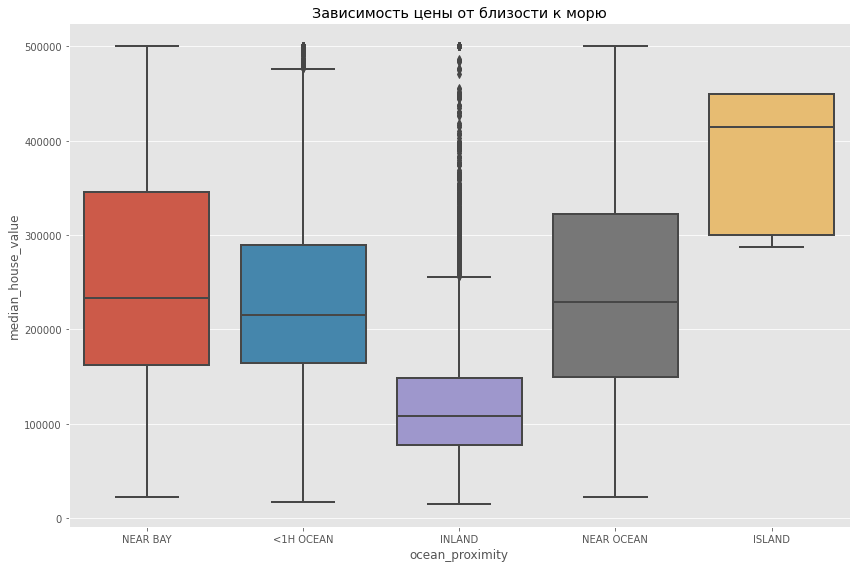

In [148]:
plt.figure(figsize = (12, 8))
sns.boxplot(x="ocean_proximity", y='median_house_value', 
            data=housing)
plt.title('Зависимость цены от близости к морю')
save_fig('boxplot')
plt.show()

In [149]:
print('='* 248)

#### Генерация фичей

In [150]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [151]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000
median_income               0.688
income_cat                  0.644
rooms_per_household         0.152
total_rooms                 0.134
housing_median_age          0.106
households                  0.066
total_bedrooms              0.050
population_per_household   -0.024
population                 -0.025
longitude                  -0.046
latitude                   -0.144
bedrooms_per_room          -0.256
Name: median_house_value, dtype: float64

In [152]:
print('='* 248)

## Кластеризация

In [153]:
dummy_df = pd.get_dummies(housing)

In [154]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   income_cat                  20640 non-null  float64
 10  rooms_per_household         20640 non-null  float64
 11  bedrooms_per_room           20433 non-null  float64
 12  population_per_household    20640 non-null  float64
 13  ocean_proximity_<1H OCEAN   206

In [155]:
dummy_df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value            1.000
median_income                 0.688
income_cat                    0.644
ocean_proximity_<1H OCEAN     0.257
ocean_proximity_NEAR BAY      0.160
rooms_per_household           0.152
ocean_proximity_NEAR OCEAN    0.142
total_rooms                   0.134
housing_median_age            0.106
households                    0.066
total_bedrooms                0.050
ocean_proximity_ISLAND        0.023
population_per_household     -0.024
population                   -0.025
longitude                    -0.046
latitude                     -0.144
bedrooms_per_room            -0.256
ocean_proximity_INLAND       -0.485
Name: median_house_value, dtype: float64

In [156]:
df = dummy_df.copy()
df.total_bedrooms.fillna(df.total_bedrooms.median(), inplace=True)
df.bedrooms_per_room.fillna(df.rooms_per_household.median(), inplace=True)

In [157]:
# удалим некоторые колонки
df.drop(['total_bedrooms', 'population', 'total_rooms'], axis=1, inplace=True)

In [158]:
df.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
households                    0
median_income                 0
median_house_value            0
income_cat                    0
rooms_per_household           0
bedrooms_per_room             0
population_per_household      0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

#### Дендрограмма

In [159]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mms = MinMaxScaler()

In [160]:
columns = df.columns
df_scaled = mms.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns = columns)

In [161]:
link = linkage(df_scaled, 'ward', 'euclidean')

In [162]:
link.shape

(20639, 4)

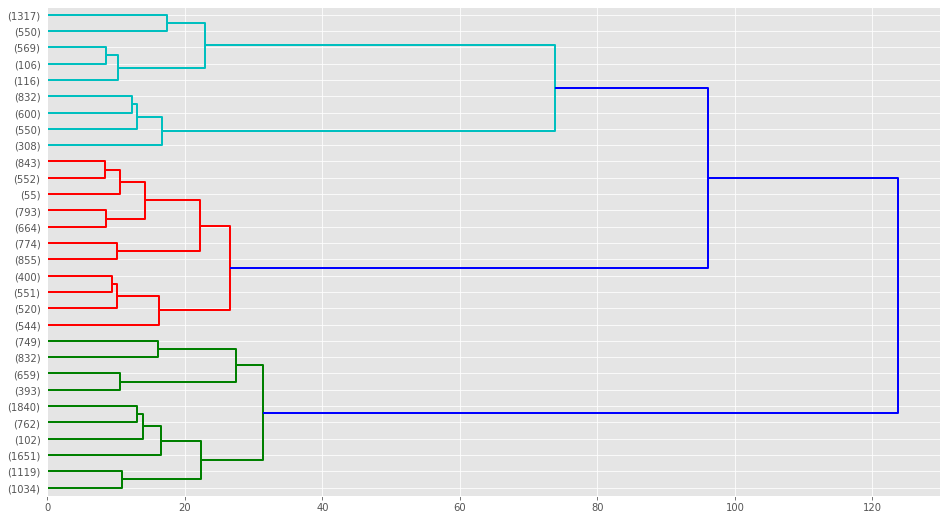

In [163]:
mpl.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)

dn = dendrogram(link, truncate_mode='lastp', orientation='right')

#### Каменистая осыпь

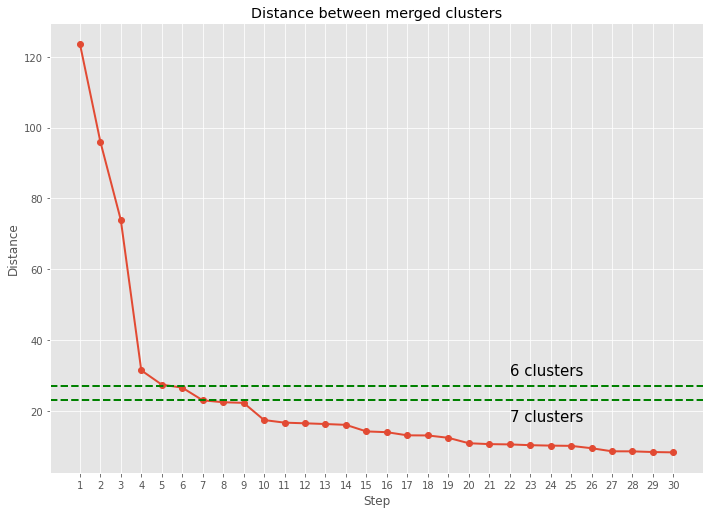

In [164]:
dist = link[-30:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(27, c='g', linestyle='dashed')
plt.axhline(23, c='g', linestyle='dashed')
plt.text(22, 17, '7 clusters', size = 15)
plt.text(22, 30, '6 clusters', size = 15)
plt.xticks(np.arange(min(idxs), max(idxs)+1, 1.0))
plt.show()

#### Кластер

In [165]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
mms = MinMaxScaler()

import time

In [166]:
def kmeans_analysis(df, x, step):
    columns = df.columns

    df_scaled = mms.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns = columns)
    
    if step==0:
        print('query: showing rows of scaled DataFrame')
        return df_scaled.sample(5)
    
    if step==1:
        print('query: correlation')
        return df_scaled.corr()
    
    if step==2:
        print('query: returning Elbow Method')
        K = range(1, 31)
        models = [KMeans(n_clusters = k, random_state=42).fit(df_scaled) for k in K]
        dist = [model.inertia_ for model in models]

        # Plot the elbow
        plt.plot(K, dist, marker='o', c='red')
        plt.xlabel('k')
        plt.ylabel('Sum of distances')
        plt.title('The Elbow Method showing the optimal k')
        return plt.show()
    
    a = int(input('Choose the amount of clusters, please: '))

    if x == 'kmeans':
      model = KMeans(n_clusters = a, random_state=42)
    
    if x == 'dbscan':
      model = DBSCAN(eps=0.18, min_samples=5)
    
    if x == 'gmm':
      model = GaussianMixture(covariance_type='full', n_components = a)

    model.fit(df_scaled)

    if x == 'gmm':
      df_scaled['cluster'] = model.predict(df_scaled)
    else:
      df_scaled['cluster'] = model.labels_
    
    if step==3:
        print('n_clusters:', a)
        print("query: df.groupby('cluster').mean()")
        return df_scaled.groupby('cluster').mean()


    if step==4:
        print('n_clusters:', a)
        print("query: df_scaled.groupby('cluster').size()")
        return df_scaled.groupby('cluster').size()
    
    if step==5:
        print('n_clusters:', a)
        print("query: df_scaled['cluster'].sort_values()")
        return df_scaled['cluster'].sort_values()
    
    fig, axs = plt.subplots(nrows=int(a/2 + 0.5), ncols=2, sharex=True)
    fig.set_size_inches(16, len(df_scaled.columns) + 2)
    plt.subplots_adjust( wspace=0.625)
    k = 0
    c = ['grey', 'violet', 'salmon', 'skyblue', 'orange', 'red', 'yellow', 'blue', 'green', 'black']
    
    if step==6:
        for i in range(int(a/2 + 0.5)):
            for j in range(2):
                try:
                    ax = axs[i, j]
                    k += 1
                    df_scaled[df_scaled.cluster == k-1].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k-1])
                    ax.tick_params(labelsize = 11)
                except TypeError:
                    break

        save_fig('cluster' + x + str(a))
        return plt.show()

In [167]:
kmeans_analysis(df, 'gmm', 0)

query: showing rows of scaled DataFrame


,longitude,latitude,housing_median_age,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6765,0.620,0.167,0.863,0.054,0.298,0.693,0.750,0.032,0.012,0.001,1.000,0.000,0.000,0.000,0.000
734,0.220,0.545,0.647,0.082,0.258,0.366,0.500,0.037,0.015,0.002,0.000,0.000,0.000,1.000,0.000
17850,0.246,0.521,0.314,0.048,0.329,0.354,0.750,0.033,0.016,0.002,1.000,0.000,0.000,0.000,0.000
6319,0.635,0.155,0.529,0.060,0.230,0.338,0.500,0.032,0.017,0.003,1.000,0.000,0.000,0.000,0.000
12769,0.292,0.646,0.784,0.036,0.105,0.103,0.250,0.029,0.029,0.001,0.000,1.000,0.000,0.000,0.000


In [52]:
kmeans_analysis(df, 'kmeans', 1)

query: correlation


,longitude,latitude,housing_median_age,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
longitude,1.000,-0.925,-0.108,0.055,-0.015,-0.046,-0.011,-0.028,0.015,0.002,0.321,-0.056,0.009,-0.474,0.046
latitude,-0.925,1.000,0.011,-0.071,-0.080,-0.144,-0.086,0.106,-0.019,0.002,-0.447,0.351,-0.017,0.359,-0.161
housing_median_age,-0.108,0.011,1.000,-0.303,-0.119,0.106,-0.147,-0.153,0.021,0.013,0.045,-0.237,0.017,0.255,0.022
households,0.055,-0.071,-0.303,1.000,0.013,0.066,0.038,-0.081,0.010,-0.027,0.042,-0.039,-0.009,-0.010,0.002
median_income,-0.015,-0.080,-0.119,0.013,1.000,0.688,0.903,0.327,-0.073,0.019,0.169,-0.237,-0.009,0.056,0.027
median_house_value,-0.046,-0.144,0.106,0.066,0.688,1.000,0.644,0.152,-0.030,-0.024,0.257,-0.485,0.023,0.160,0.142
income_cat,-0.011,-0.086,-0.147,0.038,0.903,0.644,1.000,0.313,-0.074,0.010,0.180,-0.241,-0.012,0.051,0.022
rooms_per_household,-0.028,0.106,-0.153,-0.081,0.327,0.152,0.313,1.000,-0.057,-0.005,-0.100,0.151,0.001,-0.030,-0.035
bedrooms_per_room,0.015,-0.019,0.021,0.010,-0.073,-0.030,-0.074,-0.057,1.000,-0.000,0.019,-0.024,0.000,-0.004,0.009
population_per_household,0.002,0.002,0.013,-0.027,0.019,-0.024,0.010,-0.005,-0.000,1.000,-0.002,0.015,-0.001,-0.015,-0.004


query: returning Elbow Method


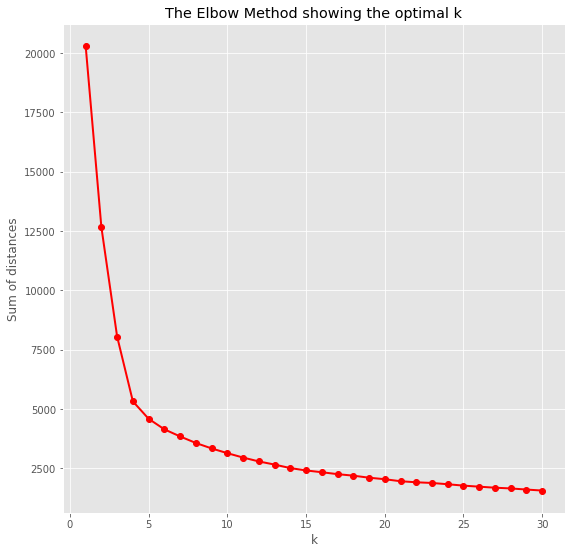

In [168]:
kmeans_analysis(df, 'gmm', 2)

In [169]:
kmeans_analysis(df,  'gmm', 3)

Choose the amount of clusters, please: 5
n_clusters: 5
query: df.groupby('cluster').mean()


,longitude,latitude,housing_median_age,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
cluster,,,,,,,,,,,,,,,
0,0.555,0.209,0.557,0.085,0.262,0.466,0.566,0.031,0.022,0.002,1.000,0.000,0.000,0.000,0.000
1,0.208,0.559,0.720,0.080,0.253,0.504,0.540,0.031,0.031,0.002,0.000,0.000,0.000,1.000,0.000
2,0.500,0.233,0.556,0.082,0.242,0.484,0.516,0.031,0.034,0.002,0.000,0.000,0.002,0.000,0.998
3,0.460,0.445,0.456,0.078,0.187,0.226,0.408,0.036,0.028,0.002,0.000,1.000,0.000,0.000,0.000
4,0.448,0.289,0.519,0.082,0.185,0.432,0.395,0.028,0.198,0.002,1.000,0.000,0.000,0.000,0.000


In [170]:
kmeans_analysis(df, 'gmm',4)

Choose the amount of clusters, please: 5
n_clusters: 5
query: df_scaled.groupby('cluster').size()


cluster
0    6551
1     613
2    2663
3    2290
4    8523
dtype: int64

In [62]:
kmeans_analysis(df, 'kmeans', 5)

Choose the amount of clusters, please: 5
n_clusters: 5
query: df_scaled['cluster'].sort_values()


7808     0
5590     0
5589     0
5588     0
5587     0
        ..
8013     4
8014     4
8016     4
8018     4
10319    4
Name: cluster, Length: 20640, dtype: int32

Choose the amount of clusters, please: 5
Saving figure clusterkmeans5


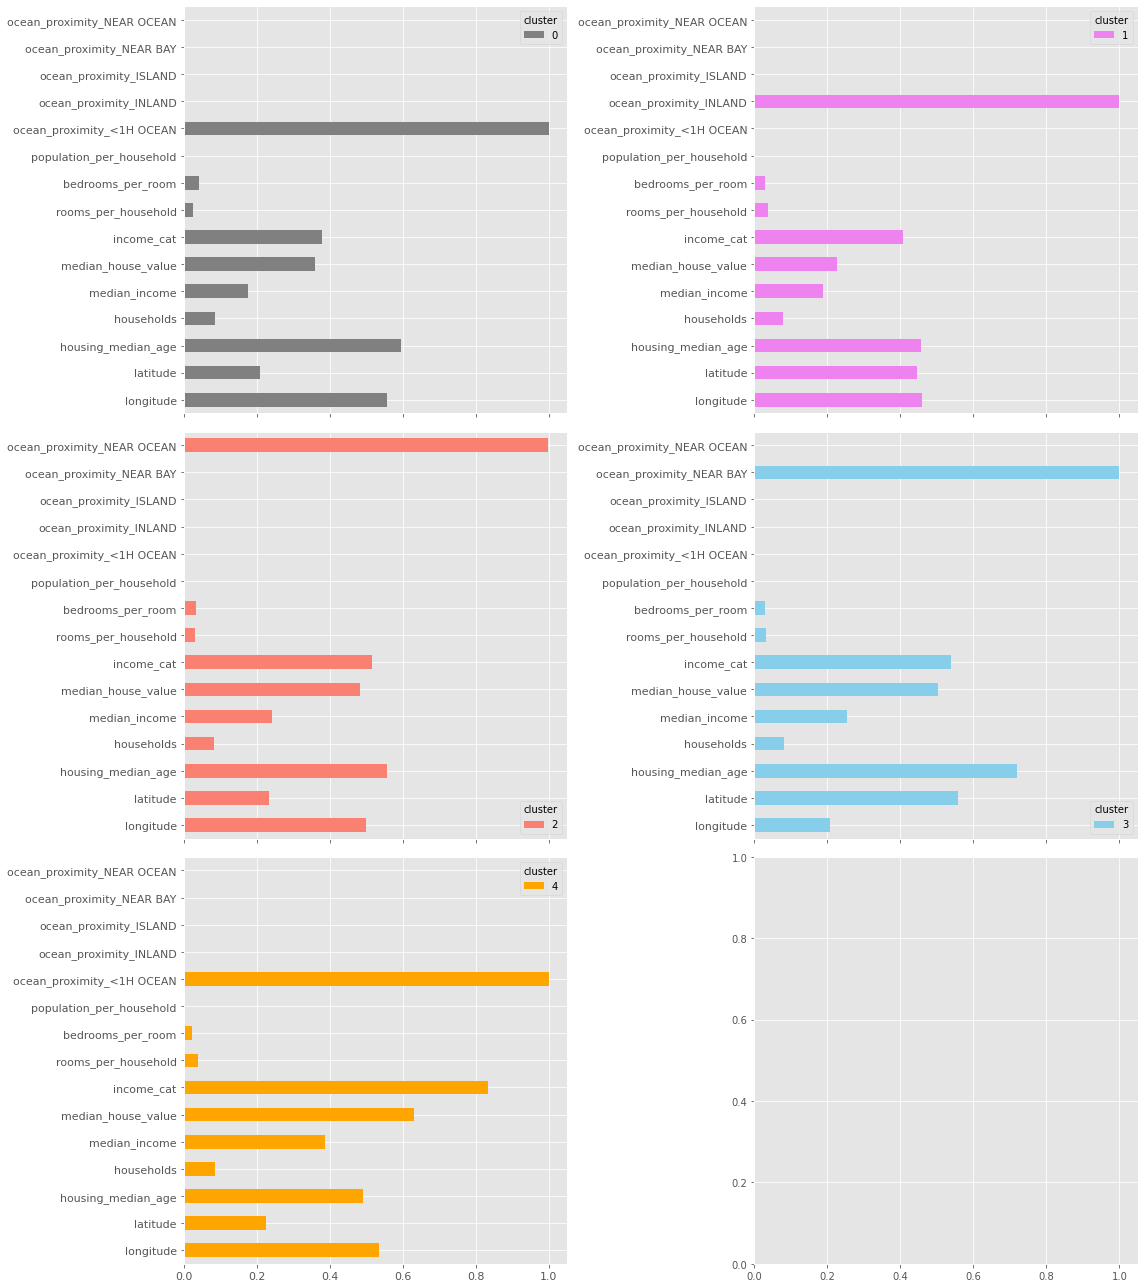

In [65]:
kmeans_analysis(df, 'kmeans', 6)

Choose the amount of clusters, please: 5
Saving figure clustergmm5


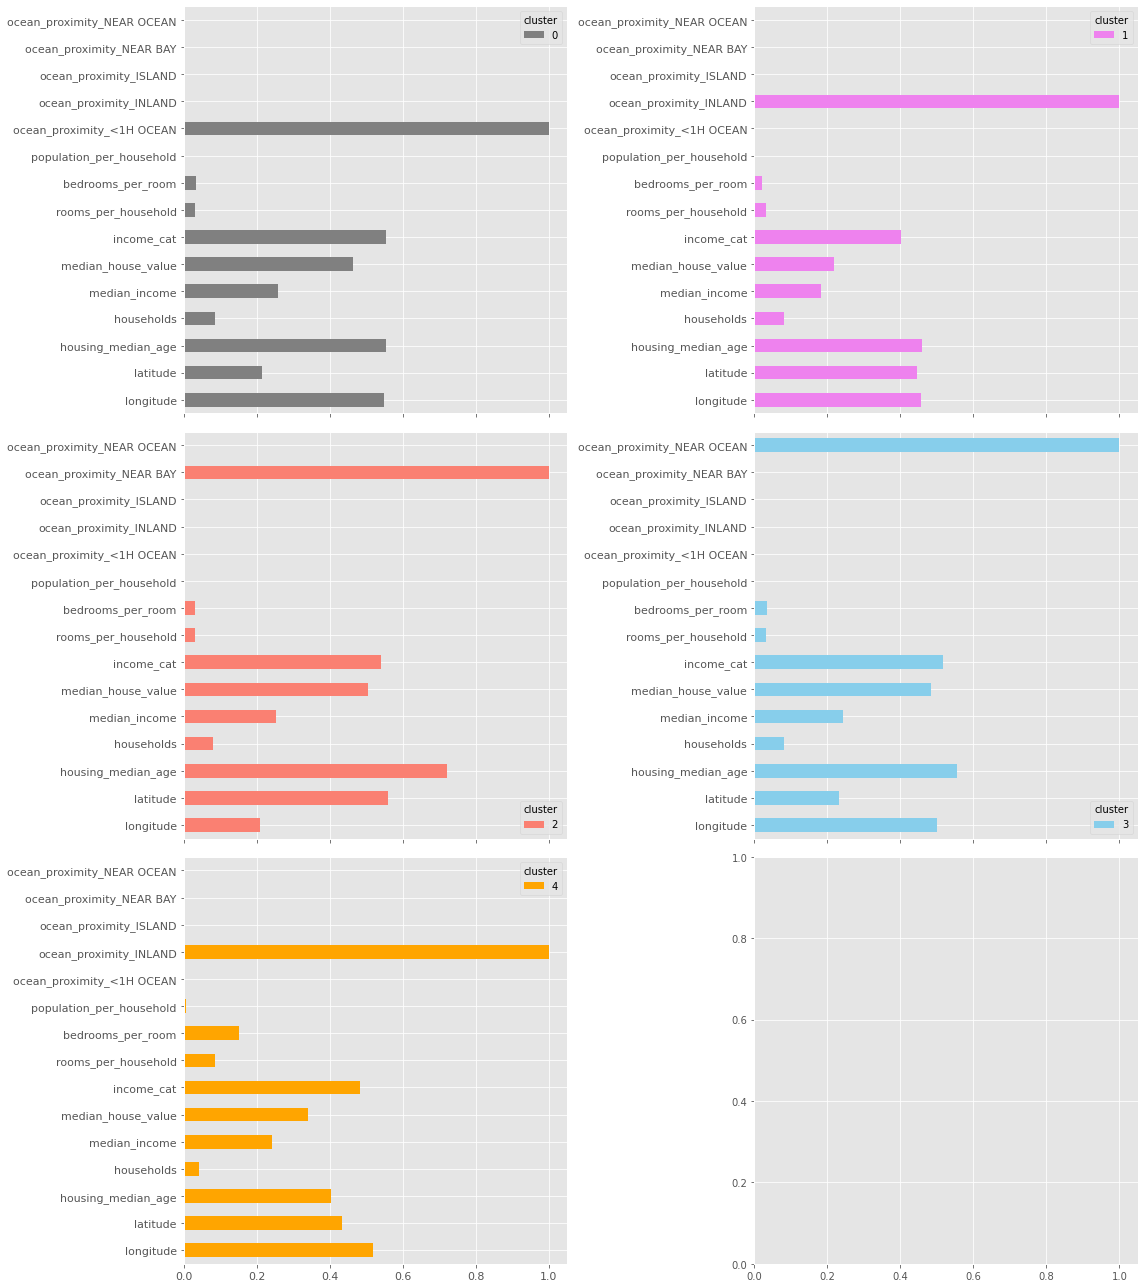

In [66]:
kmeans_analysis(df, 'gmm', 6)

Choose the amount of clusters, please: 10
Saving figure clusterdbscan10


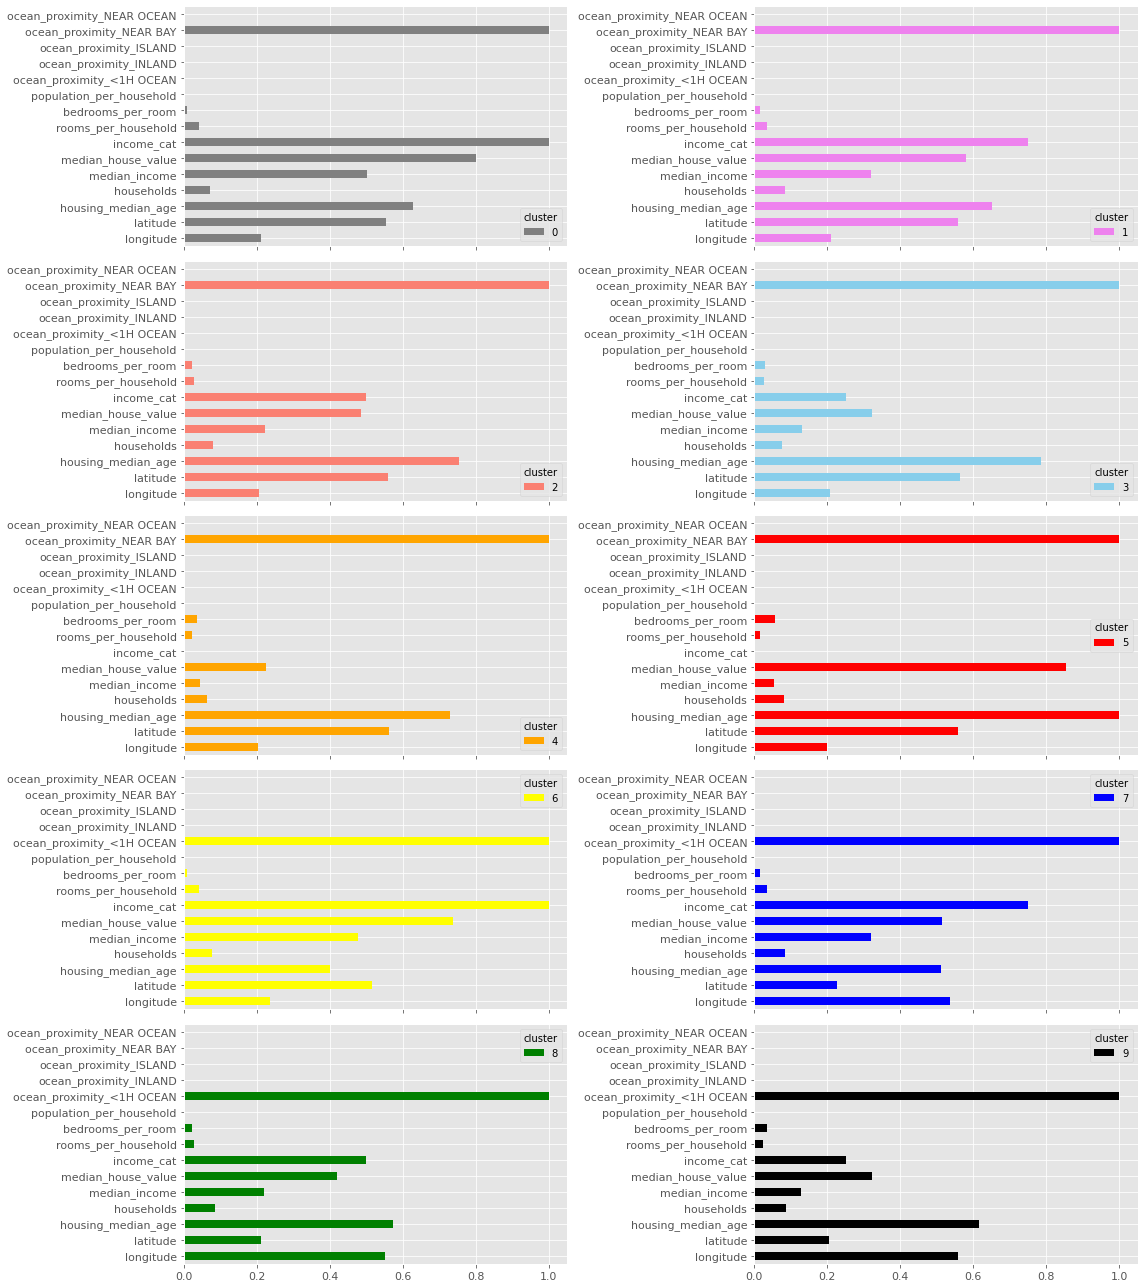

In [69]:
kmeans_analysis(df, 'dbscan', 6)

#### Понижение размерности, метод главных компонент и визуализация кластеров

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [112]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
)

In [113]:
# kmeans
n_clusters = 4
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            )

            
            
            
            ,
        ),
    ]
 )

In [105]:
# dbscan          
n_clusters = 5
clusterer = Pipeline(
    [
        (
            "kmeans",
            DBSCAN(
                  eps=0.18,
                  min_samples=5,
                                     )

            
            
            
            ,
        ),
    ]
 )

In [119]:
# GMM          
#n_clusters = 5
clusterer = Pipeline(
    [
        (
            "kmeans",
            GaussianMixture(covariance_type='full', n_components = n_clusters, random_state=42)

            
            
            
            ,
        ),
    ]
 )

In [120]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
 )

In [121]:
#n_clusters=5
pipe.fit(df)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  GaussianMixture(covariance_type='full',
                                                  init_params='kmeans',
                                                  max_iter=100, means_init=None,
                                             

In [122]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(df),
     columns=["component_1", "component_2"],
 )

#pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].predict(pipe["preprocessor"].transform(df))

In [123]:
pcadf.head()

,component_1,component_2,predicted_cluster
0,0.038,1.015,0
1,0.092,0.908,0
2,0.067,0.999,0
3,0.111,0.955,0
4,0.151,0.915,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Saving figure cluster_psa_kmeans4


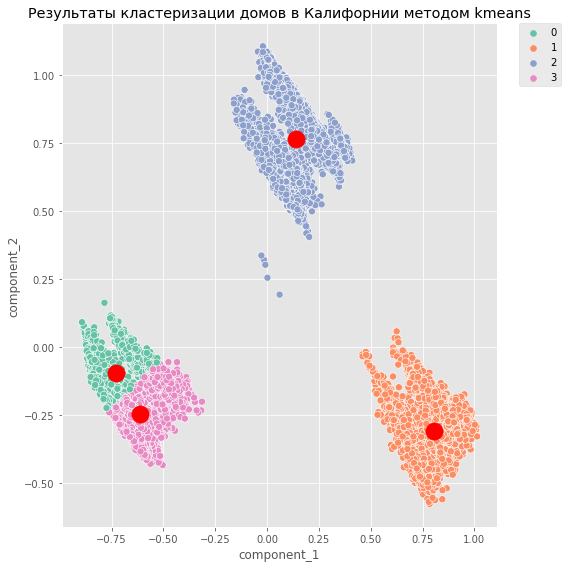

In [118]:
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange', 'red', 'yellow', 'blue', 'green', 'black']
plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
custom_palette = sns.set_palette(sns.color_palette(c))
scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     #palette=custom_palette,
     palette='Set2'
 )

scat.set_title(
     "Результаты кластеризации домов в Калифорнии методом kmeans"
 )
plt.scatter(pipe["clusterer"]["kmeans"].cluster_centers_[:, 0], pipe["clusterer"]["kmeans"].cluster_centers_[:, 1], s=300, c='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
save_fig('cluster_psa_kmeans'+ str(n_clusters))
plt.show();

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Saving figure cluster_psa_gmm4


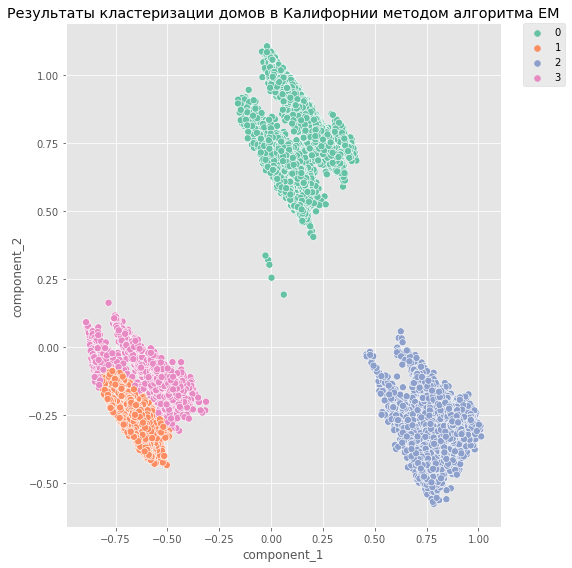

In [124]:
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange', 'red', 'yellow', 'blue', 'green', 'black']
plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
custom_palette = sns.set_palette(sns.color_palette(c))
scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     #palette=custom_palette,
     palette='Set2'
 )

scat.set_title(
     "Результаты кластеризации домов в Калифорнии методом алгоритма EM"
 )
#plt.scatter(pipe["clusterer"]["kmeans"].cluster_centers_[:, 0], pipe["clusterer"]["kmeans"].cluster_centers_[:, 1], s=300, c='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
save_fig('cluster_psa_gmm'+ str(n_clusters))
plt.show();

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Saving figure cluster_psa_dbscan5


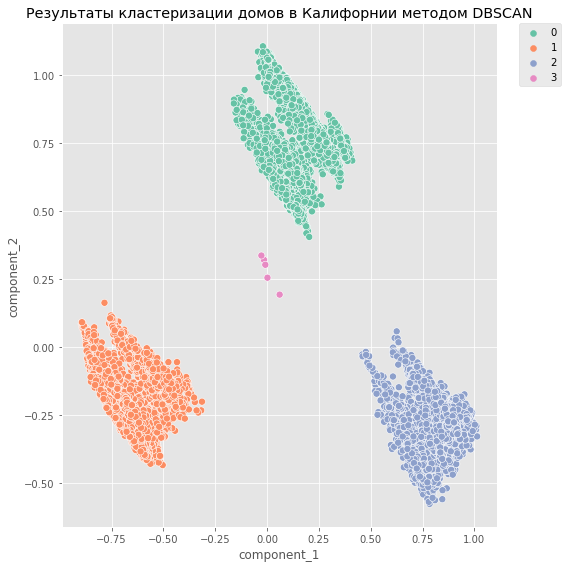

In [111]:
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange', 'red', 'yellow', 'blue', 'green', 'black']
plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
custom_palette = sns.set_palette(sns.color_palette(c))
scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     #palette=custom_palette,
     palette='Set2'
 )

scat.set_title(
     "Результаты кластеризации домов в Калифорнии методом DBSCAN"
 )
#plt.scatter(pipe["clusterer"]["kmeans"].cluster_centers_[:, 0], pipe["clusterer"]["kmeans"].cluster_centers_[:, 1], s=300, c='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
save_fig('cluster_psa_dbscan'+str(n_clusters))
plt.show();

Альтернатива (узко): Написать свой вариант алгоритма EM


Составить функцию правдопобия
для смесей

найти априорную функцию для этой функции правдоподобия

Записать апостериорную функцию

Просемплировать апостериорную (метрополис и гастингс)

посмотреть про разделение смесей нормальных распределений

Альтернатива (последняя): перенести алгоритм на Python из EM документа

Сделать 